In [1]:
from functools import partial
import fastcore.all as fc
from IPython.display import Markdown

from datasets import load_dataset

from torch import nn
from torch import optim
from torch.nn import init
import torch.nn.functional as F
from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler

from minai.learner import inplace, DataLoaders, TrainLearner, MetricsCB, ProgressCB, DeviceCB, SingleBatchCB, Learner
from minai.init import init_weights, get_model, conv, GeneralRelu, set_seed
from minai.activations import ActivationStats, Hooks
from minai.sgd import BatchSchedCB

/home/studio-lab-user/.conda/envs/fastai/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.9.3) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [2]:
bs = 1024
x, y = 'image', 'label'
ds = load_dataset('fashion_mnist')
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [3]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [4]:
dsd = ds.with_transform(transformi)
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [5]:
dls = DataLoaders.from_dd(dsd, batch_size=bs)

In [6]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(mod_filter=fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

## Going Deeper

In [7]:
def get_model(act=act_gr, nfs=(8, 16, 32, 64, 128), stride=1, norm=nn.BatchNorm2d):
    layers = [conv(1, 8, stride=stride, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs) - 1)]
    layers += [conv(nfs[-1], 10, act=None)]
    return nn.Sequential(*layers, nn.Flatten())

In [8]:
xb, yb = next(iter(dls.train))

In [9]:
model = get_model().apply(iw)

In [10]:
def _print_shape(hook, mod, inp, outp): print(type(mod).__name__, inp[0].shape, outp.shape)
learn = TrainLearner(model, dls, F.cross_entropy, [DeviceCB(), SingleBatchCB()], lr=1e-5, opt_func=optim.AdamW)
with Hooks(model, _print_shape): learn.fit(1)

Sequential torch.Size([1024, 1, 28, 28]) torch.Size([1024, 8, 28, 28])
Sequential torch.Size([1024, 8, 28, 28]) torch.Size([1024, 16, 14, 14])
Sequential torch.Size([1024, 16, 14, 14]) torch.Size([1024, 32, 7, 7])
Sequential torch.Size([1024, 32, 7, 7]) torch.Size([1024, 64, 4, 4])
Sequential torch.Size([1024, 64, 4, 4]) torch.Size([1024, 128, 2, 2])
Sequential torch.Size([1024, 128, 2, 2]) torch.Size([1024, 10, 1, 1])
Flatten torch.Size([1024, 10, 1, 1]) torch.Size([1024, 10])


In [11]:
list(learn.model[0].parameters())[0].numel()

72

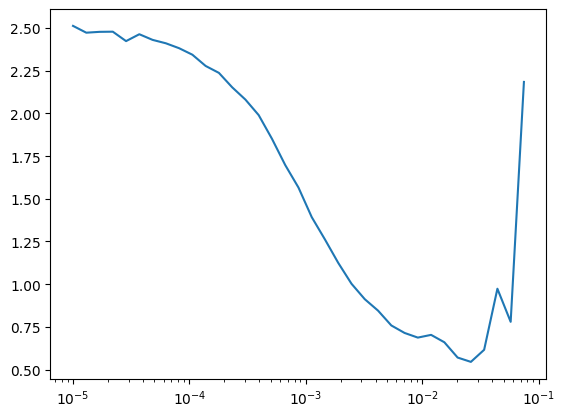

In [12]:
TrainLearner(get_model().apply(iw), dls, F.cross_entropy, [DeviceCB(), metrics], lr=1e-4, opt_func=optim.AdamW).lr_find()

accuracy,loss,epoch,train
0.825,0.482,0,True
0.868,0.365,0,False


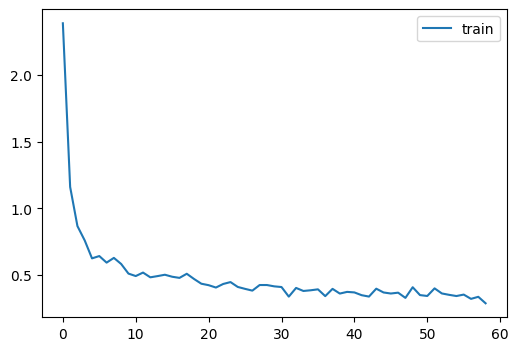

In [13]:
learn = TrainLearner(model, dls, F.cross_entropy, cbs=cbs, lr=6e-3, opt_func=optim.AdamW)
learn.fit(1)

In [14]:
@fc.patch
def summary(self:Learner):
    res = '|Layer|Input Shape|Output Shape|# of params|\n|--|--|--|--|\n'
    total_params = 0
    
    def _f(hook, mod, inp, outp):
        nonlocal res, total_params
        num_params = sum(o.numel() for o in mod.parameters())
        total_params += num_params
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{num_params}|\n'
    
    with Hooks(self.model, _f): self.fit(1, train=False, cbs=[DeviceCB(), SingleBatchCB()], lr=self.lr)
    print('Total params', total_params)
    if fc.IN_NOTEBOOK:
        return Markdown(res)
    else:
        print(res)

In [15]:
TrainLearner(get_model().apply(iw), dls, F.cross_entropy, [DeviceCB(), metrics], lr=1e-4, opt_func=optim.AdamW).summary()

Total params 110266


|Layer|Input Shape|Output Shape|# of params|
|--|--|--|--|
|Sequential|(1024, 1, 28, 28)|(1024, 8, 28, 28)|96|
|Sequential|(1024, 8, 28, 28)|(1024, 16, 14, 14)|1200|
|Sequential|(1024, 16, 14, 14)|(1024, 32, 7, 7)|4704|
|Sequential|(1024, 32, 7, 7)|(1024, 64, 4, 4)|18624|
|Sequential|(1024, 64, 4, 4)|(1024, 128, 2, 2)|74112|
|Sequential|(1024, 128, 2, 2)|(1024, 10, 1, 1)|11530|
|Flatten|(1024, 10, 1, 1)|(1024, 10)|0|


## ResBlock

In [16]:
class GlobalAvgPool(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.mean((-2, -1))

In [17]:
def conv_block(ni, nf, ks=3, stride=2, act=act_gr, norm=nn.BatchNorm2d):
    conv2 = conv(nf, nf, stride=stride, act=None, norm=norm)
    init.zeros_(conv2[1].weight)
    conv1 = conv(ni, nf, stride=1, act=act_gr, norm=norm)
    return nn.Sequential(conv1, conv2)

In [18]:
class ResBlock(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=2, act=act_gr, norm=nn.BatchNorm2d):
        super().__init__()
        self.conv_block = conv_block(ni, nf, ks=ks, stride=stride, act=act_gr, norm=norm)
        self.idconv = fc.noop if ni ==nf else conv(ni, nf, ks=1, stride=1, act=None) 
        self.pool = fc.noop if stride == 1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()
        
    def forward(self, x):
        return self.act(self.conv_block(x) + self.idconv(self.pool(x)))

In [19]:
def get_model(act=act_gr, nfs=(8, 16, 32, 64, 128, 256), stride=1, norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1]) for i in range(len(nfs) - 1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [20]:
get_model()(xb).shape

torch.Size([1024, 10])

In [21]:
TrainLearner(get_model().apply(iw), dls, F.cross_entropy, [DeviceCB(), metrics], lr=1e-4, opt_func=optim.AdamW).summary()

Total params 1228918


|Layer|Input Shape|Output Shape|# of params|
|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 8, 28, 28)|712|
|ResBlock|(1024, 8, 28, 28)|(1024, 16, 14, 14)|3696|
|ResBlock|(1024, 16, 14, 14)|(1024, 32, 7, 7)|14560|
|ResBlock|(1024, 32, 7, 7)|(1024, 64, 4, 4)|57792|
|ResBlock|(1024, 64, 4, 4)|(1024, 128, 2, 2)|230272|
|ResBlock|(1024, 128, 2, 2)|(1024, 256, 1, 1)|919296|
|Flatten|(1024, 256, 1, 1)|(1024, 256)|0|
|Linear|(1024, 256)|(1024, 10)|2570|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|


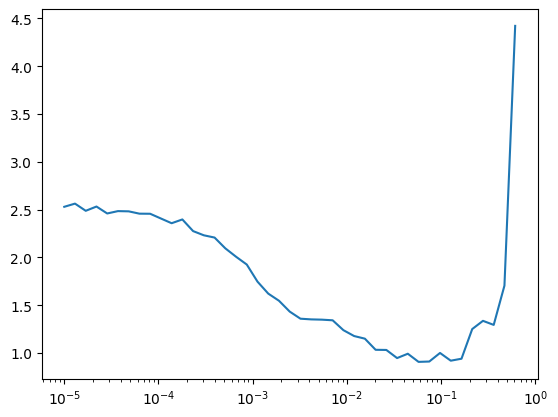

In [22]:
TrainLearner(get_model().apply(iw), dls, F.cross_entropy, [DeviceCB(), metrics], lr=1e-4, opt_func=optim.AdamW).lr_find()

accuracy,loss,epoch,train
0.689,1.056,0,True
0.728,1.259,0,False
0.872,0.419,1,True
0.713,0.937,1,False
0.896,0.309,2,True
0.878,0.350,2,False
0.916,0.247,3,True
0.895,0.309,3,False
0.932,0.204,4,True
0.917,0.239,4,False


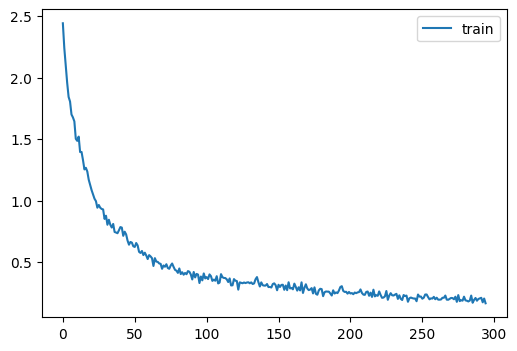

In [27]:
set_seed(42)
epochs = 5
sched = partial(lr_scheduler.OneCycleLR, max_lr=2e-2, total_steps=len(dls.train)*epochs)
xtra_cbs = [BatchSchedCB(sched)]
learn = TrainLearner(get_model().apply(iw), dls, F.cross_entropy, cbs = cbs + xtra_cbs, lr=1e-3, opt_func=optim.AdamW)
learn.fit(5)